In [1]:
import numpy as np
from scipy.stats import norm
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.animation import FuncAnimation

# Initialize Sensors, Route and Measurements

In [2]:
plt.style.use("seaborn-talk")
def initializeSensors():
    sensors=np.array([[0.5,0],[0.75,0.4],[1,1]])
    x=np.array([np.ones(5)*0.7,np.linspace(0.7,0.5,5),np.ones(5)*.5]).reshape(15)
    y=np.array([np.linspace(0,0.4,5),np.ones(5)*0.4,np.linspace(0.4,1,5)]).reshape(15)
    plt.scatter(x,y,label="Route",c="red",s=100)
    plt.scatter(sensors[:,0],sensors[:,1],label="Sensors",c="black",s=100)
    x,y=x+np.random.randn(15)*0.02,y+np.random.randn(15)*0.02
    plt.scatter(x,y,label="Actual Readings",s=100)
    plt.xlim(0,1)
    plt.legend()
    plt.show()
    return sensors

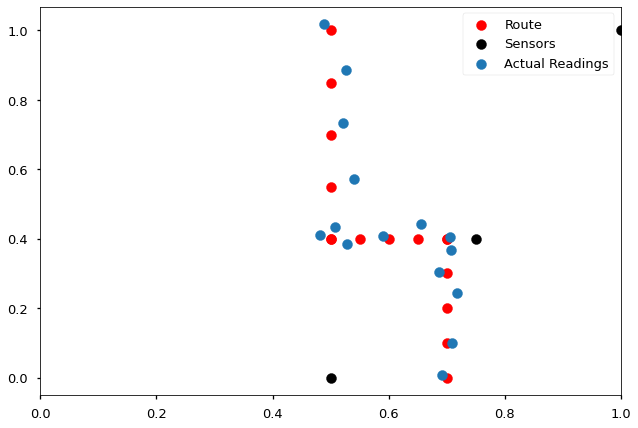

array([[0.5 , 0.  ],
       [0.75, 0.4 ],
       [1.  , 1.  ]])

In [3]:
initializeSensors()

## Step 1: Create Particles

### What are the properties of the particles?
1. X Coordinates ($x$)
2. Y Coordinates ($y$)
3. Movement ( Change / Next )

In [12]:
# Uniform Particles
def create_uniform_particles(N):
    particles=np.zeros((N,2))
    particles[:,0]=np.random.uniform(0,1,N)
    particles[:,1]=np.random.uniform(0,1,N)
    weights=np.ones(N)/N
    return particles,weights
# Gaussian
def create_normal_particles(N,std=0.3,mean=[0.5,0.5]):
    particles=np.zeros((N,2))
    particles[:,0]=mean[0]+np.random.randn(N)*std
    particles[:,1]=mean[1]+np.random.randn(N)*std
    weights=np.ones(N)/N
    return particles,weights

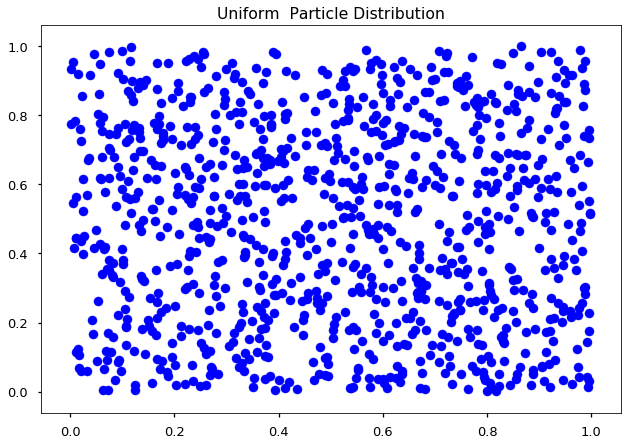

In [13]:
ps,_= create_uniform_particles(N=1000)
plt.scatter(ps[:,0],ps[:,1],c="blue")
plt.title("Uniform  Particle Distribution")
plt.show()

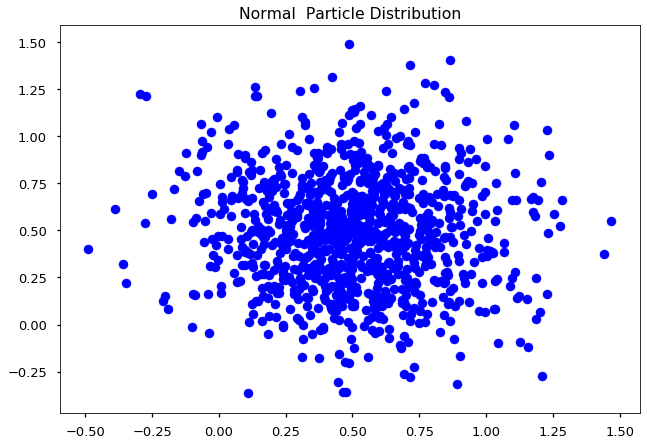

In [14]:
ps,_= create_normal_particles(N=1000)
plt.scatter(ps[:,0],ps[:,1],c="blue")
plt.title("Normal  Particle Distribution")
plt.show()

## Step 2: Predict Next State

### Robot moves 
Our filter must "track" it!
### How do we make particles move?
Simple! With the same rules that the system moves
There are two velocities, one governing the distance $v$ and the other governing the angle $\omega$


We have:
$$r_{t+1}= v + r_{t} $$
$$\theta_{t+1}= \omega + \theta_{t} $$
But these ideal velocities are often affected by noise in real life, so we give our particles some noise as well.
$$r_{t+1}= v + r_{t} + n_{t}$$
$$\theta_{t+1}= \omega + \theta_{t} + n_{t}$$
This is determined for each particle and hence we get the next state of the particles.


This is the classical model for any robot, however we know more about our robot we know it has only turn right ($90 ^{\circ}$ anti-clockwise) and left ($90 ^{\circ}$ clockwise) 
$$r_{t+1}= v + r_{t} + n_{t}$$
$$\theta_{t+1}= \delta_{\theta} + \theta_{t} $$
where 
$$\delta_{\theta}=\left\{
	\begin{array}{l}
		+\pi/2 \\
		0 \\
        -\pi/2\\ 
	\end{array}
\right.$$
with equal probabilities

In [128]:
np.random.randn()

1.1843173095500297

In [127]:
np.abs(np.random.randn()*0.1).std()

0.0

In [138]:
def predict(particles,speed=0.16,noisestd=0.01):
    N=particles.shape[0]
    prob=np.abs(np.random.randn()*0.4)
    movornot=np.random.choice([prob,1-prob],size=N)
    r=speed + (np.random.randn(N)*noisestd)
    particles[:,0]+= (r)*(1-movornot)
    particles[:,1]+= (r)*movornot
    return particles

One interesting thing to note here is the kind of noise added, although the indiviual noises are Gaussian two tailed distributions, the final coordinates are not 

## Step 3: Update the weights
### What do the weights indicate?
### How do we update them?

In [139]:
def update(particles,weights,readings,sensor_error,sensors):
    for i,sensor in enumerate(sensors):
        r=np.linalg.norm(particles[:,0:2]-sensor,axis=1)
        weights *= scipy.stats.norm(r,sensor_error).pdf(readings[i])
    weights+=1.e-300 # Avoid 0 Roundoff
    weights /= weights.sum()
    return weights

$x$-> Actual Value (Location of Robot)

$z$-> Measurement


$$ \begin{aligned}P(x \mid z) &= \frac{P(z \mid x)\, P(x)}{P(z)} \\
 &= \frac{\mathtt{likelihood}\times \mathtt{prior}}{\mathtt{normalization}}\end{aligned} $$

## Step 4: Resample
### Why is it important to resample?
### How do we resample?

In [149]:
# Uniform Resampling
def resample(particles,weights):
    N=particles.shape[0]
    index=np.arange(N)
    chosen=np.random.choice(index,size=N,p=weights)
    particles= particles[chosen]
    
    weights=np.ones(N)/N
    particles[:,0]+=np.random.randn(N)*0.01
    particles[:,1]+=np.random.randn(N)*0.01
    
    return particles,weights

<img src='resample.png'>

In [141]:
def estimate(particles,weights):
    N=particles.shape[0]
    weights=np.ones(N)/N
    return np.average(particles,axis=0)[0:2]

### Estimate:
$$\displaystyle \mu = \frac{1}{N}\sum_{i=1}^N w^ix^i$$


# Particle Filter Implementation

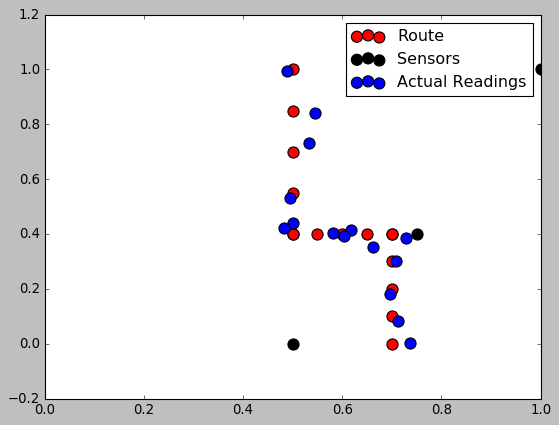

In [142]:
x=np.array([np.ones(5)*0.7,np.linspace(0.7,0.5,5),np.ones(5)*.5]).reshape(15)+np.random.randn(15)*0.01
y=np.array([np.linspace(0,0.4,5),np.ones(5)*0.4,np.linspace(0.4,1,5)]).reshape(15)+np.random.randn(15)*0.01
pos=np.vstack([np.array(x),np.array(y)]).T
sensors=initializeSensors()
measurements=np.zeros((15,3)) 
for i,sensor in enumerate(sensors):
        measurements[:,i]=np.linalg.norm(pos[:,0:2]-sensor,axis=1)+ 0.01*np.random.randn(15) 
        

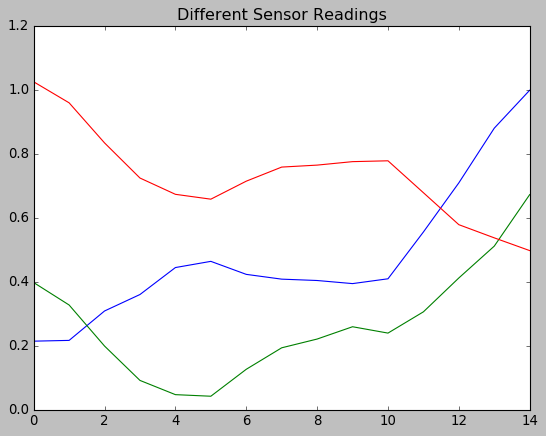

In [143]:
plt.plot(measurements[:,0])
plt.plot(measurements[:,1])
plt.plot(measurements[:,2])
plt.title("Different Sensor Readings")
plt.show()

In [147]:
def particleFilter(N=1000,sensors=sensors,measurements=measurements,init_gaus=(0,0)):
    weights=np.ones(N)/N
    particles=np.zeros((N,2,measurements.shape[0]))
    if init_gaus==(0,0):
        particles[:,:,0],weights[:]=create_uniform_particles(N)
    else:
        particles[:,:,0],weights[:]=create_normal_particles(N,0.2,[0.5,0])

    estimates=np.zeros((15,2))
    for i in range(measurements.shape[0]-1):
        particles[:,:,i]=predict(particles[:,:,i],speed=0.16,noisestd=0.2)
        weights=update(particles[:,:,i],weights,readings=measurements[i,:],sensor_error=0.01,sensors=sensors)
        estimates[i]=estimate(particles[:,:,i],weights)
        particles[:,:,i+1],weights=resample(particles[:,:,i],weights)
        #plt.scatter(x=particles[:,0,i].mean(),y=particles[:,1,i].mean())
    return particles,estimates

## Predict,Update and Resample for a few steps...


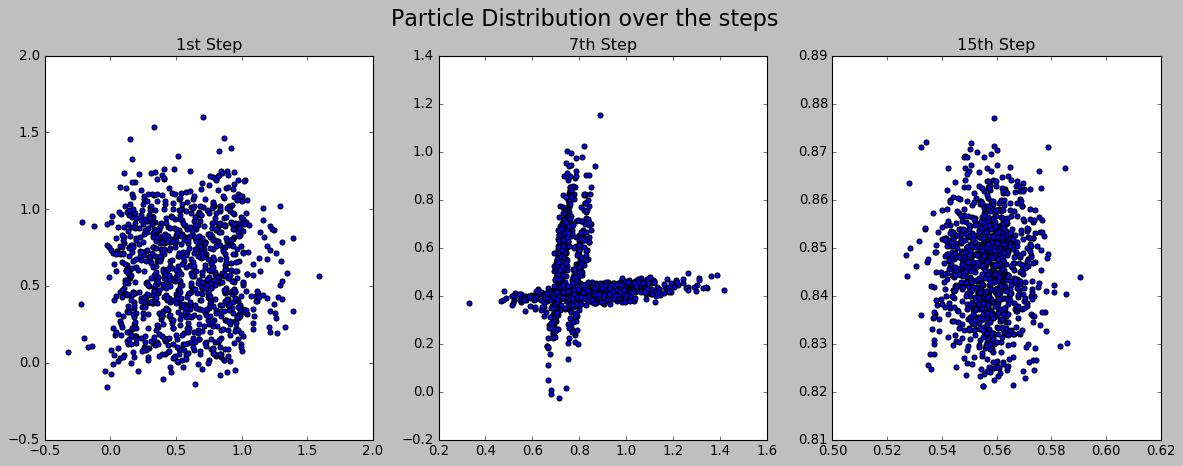

In [148]:
ps,_=particleFilter(1000,init_gaus=(0,0))
fig,axs=plt.subplots(1,3,figsize=(18,6))
axs[0].scatter(ps[:,0,0],ps[:,1,0])
axs[1].scatter(ps[:,0,6],ps[:,1,6])
axs[2].scatter(ps[:,0,14],ps[:,1,14])
axs[0].set_title("1st Step")
axs[1].set_title("7th Step")
axs[2].set_title("15th Step")
plt.suptitle("Particle Distribution over the steps",size=20,y=1.)
plt.show()

In [162]:
time_step=10
weights=update(ps[:,:,time_step],np.ones(1000)/1000,readings=measurements[time_step,:],sensor_error=0.01,sensors=sensors)
rs=resample(ps[:,:,time_step],weights)[0]

In [182]:
from ipywidgets import interact, IntSlider
ps,est=particleFilter(1000,init_gaus=(0,0))
def simulate(time_step):
    fig,axs=plt.subplots(1,1,figsize=(8,8))
    axs.scatter(ps[:,0,time_step],ps[:,1,time_step],alpha=0.5,label="Predicted Particles")
    axs.scatter(est[time_step][0],est[time_step][1],marker="P",s=700,color="black",label="Estimate")
    weights=update(ps[:,:,time_step],np.ones(1000)/1000,readings=measurements[time_step,:],sensor_error=0.01,sensors=sensors)
    rs=resample(ps[:,:,time_step],weights)[0]
    axs.scatter(rs[:,0],rs[:,1],color="yellow",label="Resampled")
    axs.scatter(pos[time_step][0],pos[time_step][1],marker="X",s=700,color="red",label="Object")
    axs.set_xlim(0,1)
    axs.set_ylim(0,1) 
    axs.legend()
    plt.show()

interact(simulate, time_step=IntSlider(value=0, max=14));

interactive(children=(IntSlider(value=0, description='time_step', max=14), Output()), _dom_classes=('widget-in…

In [157]:
import matplotlib
?matplotlib.markers

In [52]:
M=100
#avg=np.zeros((M,15,2))
def run_iter(i):
    return particleFilter(1000,sensors,measurements,init_gaus=(1,1))
from multiprocessing import Pool
with Pool() as pool:
    avg=pool.map(run_iter,range(M))


In [46]:
### Code to generate gif
np.array(avg[0])#.mean(axis=0)[i]
pts=np.array(avg)[:,0].mean(axis=0).mean(axis=0)

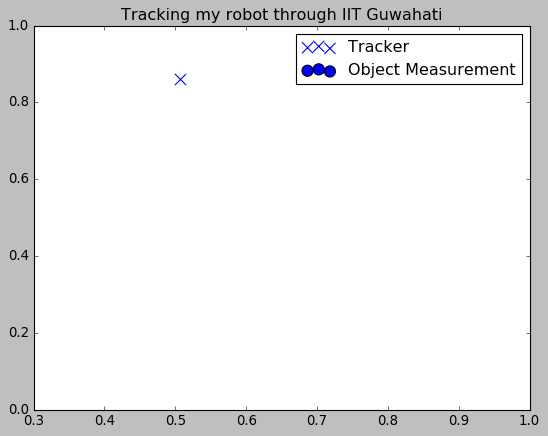

In [48]:

import matplotlib.pyplot as plt 
import matplotlib.animation as animation 
import numpy as np 
plt.style.use("classic")
fig = plt.figure() 
ax = plt.axes(xlim=(0.3, 1), ylim=(0, 1)) 
scat = ax.scatter(x=[],y= [],marker='x',label="Tracker",s=100) 
scat1=ax.scatter(x=[],y=[],label="Object Measurement",s=100)
# initialization function 
def init(): 
    # creating an empty plot/frame 
    return scat,scat1

# lists to store x and y axis points 
xdata, ydata = [], [] 

# animation function 
def animate(i): 
    
    # appending new points to x, y axes points list 
    pts=np.array(avg)[:,0].mean(axis=0).mean(axis=0)
    scat.set_offsets([pts[0][i],pts[1][i]])
    scat1.set_offsets(pos[i])
    return scat,scat1


# setting a title for the plot 
plt.title('Tracking my robot through IIT Guwahati') 
# hiding the axis details 
plt.legend()
# call the animator	 
anim = animation.FuncAnimation(fig, animate, init_func=init, 
							frames=15, interval=400, blit=True) 

# save the animation as mp4 video file 
anim.save('during.gif',writer='imagemagick') 



### Importance Sampling
The expected value of a function $f(x)$ with probability distribution $\pi(x)$ is

$$\mathbb{E}\big[f(x)\big] = \int f(x)\pi(x)\, dx$$
but our problem is that we don't know the probability distribution $\pi(x)$ , which the distribution of the robot on the x-plane, if we knew it there won't be any need do to all this, we could simply monte-carlo integrate this  equation,
$$\mathbb{E}\big[f(x)\big] = \int f(x)\pi(x)\frac{q(x)}{q(x)}\, dx$$
$$\mathbb{E}\big[f(x)\big] = \int f(x)q(x)\, \,  \cdot \,  \frac{\pi(x)}{q(x)}\, dx$$
$q(x)$ is known to us, so we can compute $\int f(x)q(x)$ using MC integration. That leaves us with  $\pi(x)/q(x)$.  That is a ratio, and we define it as a *weight*. This gives us
$$\mathbb{E}\big[f(x)\big] = \sum\limits_{i=1}^N f(x^i)w(x^i)$$
$$\displaystyle \mu = \frac{1}{N}\sum_{i=1}^N w^ix^i$$
